# Multi-representation Indexing

Summary Embeddingによる検索文章の要約  
チャンクはSemantic Chunking

https://qiita.com/shimajiroxyz/items/facf409b81f59bb68775

In [1]:
import os
import pandas as pd
import openai
import datetime
import tiktoken
import uuid
from sudachipy import tokenizer
from sudachipy import dictionary
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import MultiVectorRetriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [2]:
# OpenAI APIキーを設定
openai.api_key = input()

## テキスト読み込み

In [3]:
novel_file_path = "../data/novels_preprocess_2/works/"

In [4]:
# .txt ファイルを読み込み、ドキュメントをリスト化
documents = []
for filename in os.listdir(novel_file_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(novel_file_path, filename)
        loader = TextLoader(file_path, encoding="utf-8")
        documents.extend(loader.load())

In [1]:
documents

In [6]:
page_contents_list = [doc.page_content for doc in documents]
page_contents = "\n".join(page_contents_list)

In [7]:
sentences_list = page_contents.split("\n")

In [2]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences_list)]
sentences[:3]

In [9]:
len(sentences)

7750

## Embedding

In [10]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [11]:
# OpenAIの埋め込みモデルを使ってドキュメントをベクトル化
embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\900527064.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)


In [12]:
embeddings = embedding.embed_documents([x['combined_sentence'] for x in sentences])

In [13]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

## 類似度比較

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [15]:
distances, sentences = calculate_cosine_distances(sentences)
distances[:3]

[0.051973627120077026, 0.026729114326370818, 0.04455227061023881]

### 類似度確認

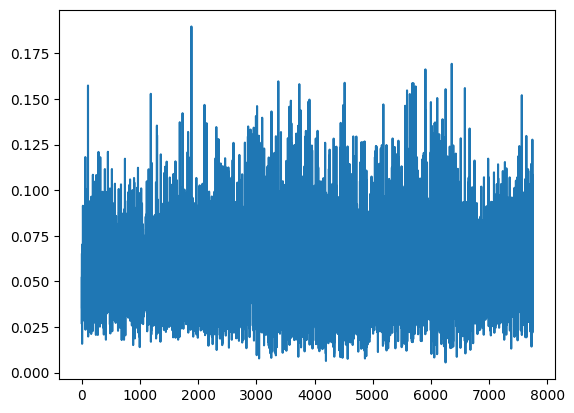

In [16]:
import matplotlib.pyplot as plt

plt.plot(distances)

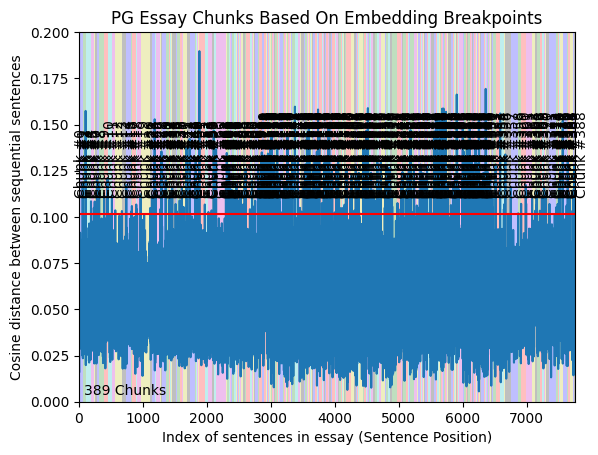

In [17]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## チャンク分割

In [18]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

In [3]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

In [20]:
len(chunks)

389

## Summary Embedding

In [21]:
# OpenAIの言語モデルを設定（ここではGPT-3を使用）
# llm_mini = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai.api_key)
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\1360590322.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)


### 検索用要約文章の作成

In [22]:
chain = (
    {"doc": lambda x: x}
    | ChatPromptTemplate.from_template("以下の文章を重要なキーワードは残して要約してください。:\n\n{doc}")
    | llm
    | StrOutputParser()
)

In [23]:
summaries = chain.batch(chunks, {"max_concurrency": 1})

In [4]:
summaries

In [25]:
# 要約テキストを保存
summaries_df = pd.DataFrame({"summary":summaries})
summaries_df.to_csv("../data/novels_preprocess_2/summary.csv", index=None, encoding="utf-8-sig")

In [26]:
summaries_df = pd.read_csv("../data/novels_preprocess_2/summary.csv", encoding="utf-8-sig")

In [27]:
summaries = summaries_df["summary"].tolist()

### vectore storeに保存

In [28]:
from langchain_core.documents import Document
chunks_document = [
    Document(page_content=s) for s in chunks
]

In [5]:
chunks_document

In [30]:
from langchain_community.vectorstores import Chroma
from langchain_core.stores import InMemoryByteStore
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embedding)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
    top_k=10,
)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\1181676942.py:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(collection_name="summaries", embedding_function=embedding)
No embedding_function provided, using default embedding function: DefaultEmbeddingFunction https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


In [31]:
doc_ids = [str(uuid.uuid4()) for _ in chunks_document]

summary_docs = [
    Document(page_content=s, metadata={"id_key": doc_ids[i]})
    for i, s in enumerate(summaries)
]
# metadatas = []
# for subdoc, doc_id in zip(summaries, doc_ids):
#     metadatas += [{ID_KEY: doc_id}]

In [6]:
summary_docs

In [33]:
# retriever.vectorstore.add_texts(summaries, metadatas)
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, chunks_document)))

In [34]:
# ドキュメントの数を確認
doc_count = retriever.vectorstore._collection.count()
print(f"Number of documents in vectorstore: {doc_count}")

Number of documents in vectorstore: 389


In [35]:
# ベクトルストアに格納されたドキュメントを取得して確認する
documents = retriever.vectorstore.similarity_search("test query", k=1)
print("Retrieved Documents:", documents[0])

Retrieved Documents: page_content='かしこまりました。文章を提供していただけますか？' metadata={'id_key': '52cc1dc2-6c59-44bd-8e0d-5a74beae305f'}


## 以下、通常のRAG

In [36]:
# SudachiPyの初期設定
tokenizer_obj = dictionary.Dictionary().create()

In [37]:
# SudachiPyを使用して名詞・動詞・形容詞のみを抽出する関数
def extract_relevant_words(query):
    mode = tokenizer.Tokenizer.SplitMode.C  # モードを指定
    tokens = tokenizer_obj.tokenize(query, mode)
    
    # 名詞、動詞、形容詞のみを抽出
    relevant_words = []
    for token in tokens:
        pos = token.part_of_speech()[0]  # 品詞情報を取得
        if pos in ["名詞", "動詞", "形容詞"]:
            relevant_words.append(token.surface())  # 単語の表層形を取得
    
    return " ".join(relevant_words)

In [38]:
# 6. 回答を50トークン以内に制限し、引用を含むプロンプトを作成
prompt_template = """あなたは正確性の高いQAシステムです。
事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
以下のルールに従って回答してください。:
1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
2. 回答内で指定されたコンテキストを直接参照しないでください。
3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
4. 回答は50トークン以内で簡潔に回答してください。
5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。

コンテキスト: {context}
質問: {question}
回答:"""
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])


In [39]:
# 検索用のQAチェーンを構築
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # "stuff" モードはシンプルに関連ドキュメントをまとめて渡すモード
    retriever=retriever,
    return_source_documents=True,  # 検索結果としてソースドキュメントを返す
    chain_type_kwargs={"prompt": prompt}
)

## 質問ファイルを読み込んでQ&Aを作成

In [40]:
# 提供されたCSVファイルを読み込み
query_df = pd.read_csv("../data/query.csv", encoding="utf-8")

In [7]:
query_df.head()

In [42]:
def answers_def(problem: str, context: str) -> str:

    prompt = PromptTemplate(
        input_variables=["problem", "context"],
        template=
            """あなたは正確性の高いQAシステムです。
            事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
            以下のルールに従って回答してください。:
            1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
            2. 回答内で指定されたコンテキストを直接参照しないでください。
            3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
            4. 回答は50トークン以内で簡潔に回答してください。
            5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。

            コンテキスト: {context}
            質問: {problem}
            回答:"""
    )
    chain = prompt | llm

    response = chain.invoke(
        {"problem": problem, "context": context}
    )
    return response.content

In [8]:
answers = []
evidences = []

for _, row in query_df.iterrows():
    print(_)
    query = row["problem"]
    # processed_query = extract_relevant_words(query)  # 質問を前処理して名詞・動詞・形容詞だけを抽出
    print(query)
    # print(processed_query)
    search = retriever.vectorstore.similarity_search(query, k=5)
    print(search[0].page_content)
    answers_str = answers_def(query, search[0].page_content)
    print(answers_str)
    # answer = result["result"]
    # print(answer)
    # evidence = result["source_documents"][0].page_content # 証拠部分を抽出
    answers.append(answers_str)
    evidences.append(search[0].page_content)

In [44]:
# DataFrameに回答と証拠を追加
query_df['full_answer'] = answers
query_df['evidence'] = evidences

In [45]:
replace_dict = {
        "\n": "",
        "\r": "",
    }

query_df = query_df.replace(
        {"evidence": replace_dict},
        regex=True
    )

In [9]:
query_df.head(10)

In [47]:
# LLMを使って要約を行う関数
def summarize_answer(problem: str, full_answer: str, evidence: str) -> str:

    summarize_prompt = PromptTemplate(
        input_variables=["problem", "full_answer", "evidence"],
        template=
            """以下のQuestionに対するAnswerの文章をEvidenceを元に50文字以内に収まるように簡潔に答え直してください。
            50文字以内に収まらない場合、要約して一言で答えてください。
            回答だけを答えてください。
                f"Question: {problem}\n\n"
                f"Answer: {full_answer}\n"
                f"Evidence: {evidence}\n"
            回答:"""
    )
    chain = summarize_prompt | llm

    response = chain.invoke(
        {"problem": problem, "full_answer": full_answer, "evidence": evidence}
    )
    return response.content

In [48]:
# tiktokenとgpt-4のトークナイザーを取得
enc = tiktoken.encoding_for_model("gpt-4-2024-08-06")

# query_df の "answer" 列のトークン数を計算し、50トークンを超える場合は要約を行う関数
def check_and_summarize_answers(query_df: pd.DataFrame) -> pd.DataFrame:
    def summarize_if_needed(problem: str, full_answer: str, evidence: str) -> str:
        # トークン数を計算
        token_count = len(enc.encode(full_answer))
        print(token_count)
        
        # トークン数が50を超えた場合は要約する
        if token_count > 50:
            # LLMを使って要約
            summarized_answer = summarize_answer(problem, full_answer, evidence)
            return summarized_answer
        return full_answer

    # "answer" 列に対して処理を適用
    query_df["answer"] = query_df["full_answer"]
    for i in range(len(query_df.index)):
        query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
    return query_df

In [10]:
query_df = check_and_summarize_answers(query_df)

In [11]:
query_df.head(20)

In [51]:
# 必要な列（id, answer, evidence）をヘッダなしでCSVに書き出し
query_df[['index', 'answer', 'evidence']].to_csv(
    "../submit/predictions.csv",
    index=False,
    header=False,
    encoding="utf-8-sig"
)

In [52]:
# backup
dt_now = datetime.datetime.now()
ymdm = dt_now.strftime("%Y%m%d-%H%M")

query_df[['index', 'problem', 'full_answer', 'answer', 'evidence']].to_csv(
    f"../submit/{ymdm}_predictions.csv",
    index=False,
    header=True,
    encoding="utf-8-sig"
)